## Approach

Find a weight for Jaccard similarity (see [baseline.ipynb](./baseline.ipynb)) and recipe popularity percentile (see [baselines.ipy](./baselines.py)), and calculate the weighed average.

If the weighed average >= a value we set (here we use 0.5), the user_id and recipe_id combination is predicted to be actually have happened.

importing Jupyter notebook from baseline.ipynb


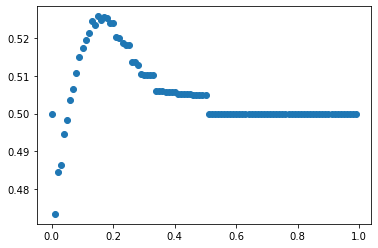

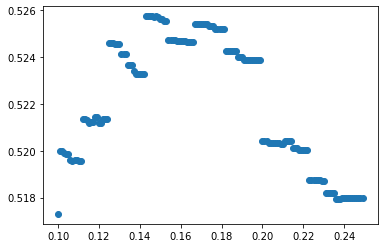

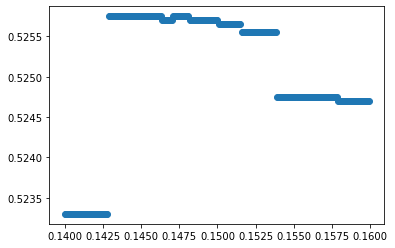

In [2]:
# make ipynb files importable
from jupyter_utils_tddschn import notebook_importer

# import the baseline.ipynb file
import baseline

In [3]:
from baseline import *

In [7]:
d.shape
X_train.shape
recipes_train = X_train[:, :-1]
recipes_train = recipes_train.copy()
recipes_train.resize((X_train.shape[0],))
recipes_train.shape

(490000,)

In [8]:
from collections import Counter, defaultdict
import numpy as np
recipe_counts = Counter(recipes_train)

In [9]:
recipe_counts.most_common(3)

[(32445558, 4671), (95482435, 3418), (54496210, 2847)]

In [10]:
most_common_recipes = recipe_counts.most_common()

In [16]:
most_common_recipes_id_normalized = [(i + 1, most_common_recipes[i][1]) for i in range(len(most_common_recipes))]

In [17]:
len(most_common_recipes_id_normalized)
most_common_recipes_id_normalized[:3], most_common_recipes_id_normalized[-3:]

([(1, 4671), (2, 3418), (3, 2847)], [(13514, 1), (13515, 1), (13516, 1)])

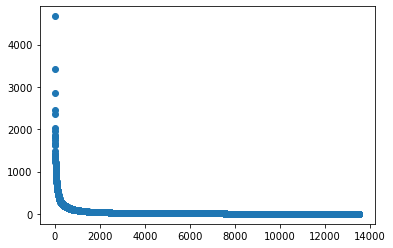

In [18]:
plt.scatter(*zip(*most_common_recipes_id_normalized, strict=True))
plt.show()

In [21]:
recipe_quantiles: dict[int, float] = {}
cum_count = 0
for recipe, count in most_common_recipes:
	recipe_quantiles[recipe] = cum_count / len(recipes_train)
	cum_count += count


In [22]:
import itertools
dict(itertools.islice(recipe_quantiles.items(), 5))

{32445558: 0.0,
 95482435: 0.00953265306122449,
 54496210: 0.016508163265306124,
 43615275: 0.022318367346938775,
 59129763: 0.027351020408163264}

In [23]:
recipe_quantiles_values = list(recipe_quantiles.values())
recipe_quantiles_id_normalized: list[int, float] = [(i + 1, recipe_quantiles_values[i]) for i in range(len(recipe_quantiles_values))]

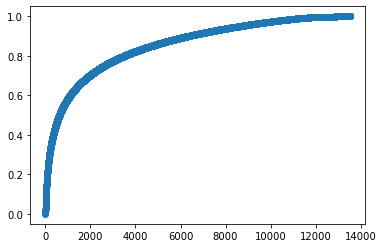

In [24]:
plt.scatter(*zip(*recipe_quantiles_id_normalized, strict=True))
plt.show()

In [33]:
from collections import defaultdict
jaccard_max_sims_dict: dict[tuple[int, int], float] = defaultdict(float)
for u, r in X_test_and_random:
	jaccard_max_sims_dict[(u, r)] = jaccard_sim_max(u, r)

In [35]:
def get_prediction_score(weight1: float, weight2: float, user_id: int, recipe_id: int) -> float:
	# sim_max = jaccard_sim_max(user_id, recipe_id)
	sim_max = jaccard_max_sims_dict[(user_id, recipe_id)]
	return weight1 * sim_max + weight2 * recipe_quantiles.get(recipe_id, 0.0)

def get_prediction(weight1: float, weight2: float, user_id: int, recipe_id: int) -> bool:
	return get_prediction_score(weight1, weight2, user_id, recipe_id) >= 0.5

In [29]:
# get the number of elements in np.arange(start, stop, step)
def numpy_arange_element_count(start: float, stop: float, step: float) -> int:
	mod = (stop - start) / step
	return int(mod) + int(mod != int(mod))

In [47]:
import seaborn as sns

def get_accuracies(start, stop, step, start2, stop2, step2) -> list[tuple[float, float, float]]:
	accuracies: list[tuple[float, float, float]] = []
	d1, d2 = numpy_arange_element_count(start, stop, step), numpy_arange_element_count(start2, stop2, step2)
	for weight1 in np.arange(start, stop, step):
		for weight2 in np.arange(start2, stop2, step2):
			predictions_binary = [get_prediction(weight1, weight2, u, r) for u, r in X_test_and_random]
			accuracy = sum(predictions_binary) / len(predictions_binary)
			accuracies.append((weight1, weight2, accuracy))
	arr = np.zeros((d1, d2))
	return accuracies

def plot_heatmap(accuracies: list[tuple[float, float, float]]) -> None:
	x, y, z = zip(*accuracies)
	heatmap, _, _ = np.histogram2d(x, y, weights=z)
	plt.clf()
	plt.imshow(heatmap, cmap='hot')
	plt.show()

In [39]:
accu = get_accuracies(0, 1, 0.1, 0, 1, 0.1)

In [41]:
accu[:3], accu[8:12]

([(0.0, 0.0, 0.0), (0.0, 0.1, 0.0), (0.0, 0.2, 0.0)],
 [(0.0, 0.8, 0.0539), (0.0, 0.9, 0.05475), (0.1, 0.0, 0.0), (0.1, 0.1, 0.0)])

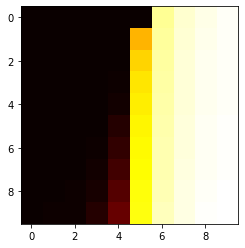

In [48]:
plot_heatmap(accu)

In [49]:
accu2 = get_accuracies(0.5, 1, 0.05, 0.5, 1, 0.05)

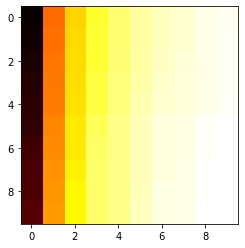

In [50]:
plot_heatmap(accu2)

## Conclusion

The best result was achieved when both weights were set to 1.